# Changes in religious affiliation and attendance

Analysis based on data from the [CIRP Freshman Survey](https://heri.ucla.edu/cirp-freshman-survey/)

Copyright Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, savefig

import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('error')

Read the data.  Note: I transcribed these data manually from published documents, so data entry errors are possible.

In [2]:
df = pd.read_csv('freshman_survey.csv', skiprows=2, index_col='year')
df[df.columns] /= 10
df.head()

,noneall,fatherall,motherall,attendedall,nonemen,fathermen,mothermen,attendedmen,nonewomen,fatherwomen,motherwomen,attendedwomen,bornagain,evangelical
year,,,,,,,,,,,,,,
1966,NaN,NaN,NaN,66.1,NaN,NaN,NaN,59.0,NaN,NaN,NaN,74.0,NaN,NaN
1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968,NaN,NaN,NaN,91.7,NaN,NaN,NaN,90.0,NaN,NaN,NaN,93.7,NaN,NaN
1969,13.6,NaN,NaN,91.0,15.7,NaN,NaN,89.2,2.3,NaN,NaN,93.0,NaN,NaN
1970,10.7,NaN,3.1,89.0,11.9,NaN,2.8,87.4,9.1,NaN,3.3,90.9,NaN,NaN


In [3]:
df.tail()

,noneall,fatherall,motherall,attendedall,nonemen,fathermen,mothermen,attendedmen,nonewomen,fatherwomen,motherwomen,attendedwomen,bornagain,evangelical
year,,,,,,,,,,,,,,
2015,29.6,16.6,16.4,69.5,31.8,NaN,NaN,67.8,27.7,NaN,NaN,70.8,NaN,NaN
2016,30.9,NaN,NaN,68.9,33.1,NaN,NaN,67.1,29.1,NaN,NaN,70.4,NaN,NaN
2017,30.2,NaN,NaN,69.2,31.9,NaN,NaN,67.7,28.8,NaN,NaN,70.4,NaN,NaN
2018,31.1,NaN,NaN,67.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019,33.6,NaN,NaN,65.7,35.2,NaN,NaN,64.6,32.2,NaN,NaN,66.6,NaN,NaN


Compute time variables for regression analysis, centered on 1966 (which makes the estimated intercept more interpretable).

In [4]:
df['time'] = df.index - 1966
df['time2'] = df.time**2

The following functions fits a regression model and uses a permutation method to estimate uncertainty due to random sampling.

In [5]:
def make_error_model(df, y, formula, n=100):
    """Makes a model that captures sample error and residual error.

    df: DataFrame
    y: Series
    formula: string representation of the regression model
    n:     number of simulations to run

    returns: (fittedvalues, sample_error, total_error)
    """
    # make the best fit
    df['y'] = y
    results = smf.ols(formula, data=df).fit()
    fittedvalues = results.fittedvalues
    resid = results.resid    

    # permute residuals and generate hypothetical fits
    fits = []
    for i in range(n):
        df['y'] = fittedvalues + np.random.permutation(results.resid)
        fake_results = smf.ols(formula, data=df).fit()
        fits.append(fake_results.fittedvalues)

    # compute the variance of the fits
    fits = np.array(fits)
    sample_var = fits.var(axis=0)
    
    # add sample_var and the variance of the residuals
    total_var = sample_var + resid.var()

    # standard errors are square roots of the variances
    return fittedvalues, np.sqrt(sample_var), np.sqrt(total_var)

Plot a region showing a confidence interval.

In [6]:
def fill_between(fittedvalues, stderr, **options):
    """Fills in the 95% confidence interval.
    
    fittedvalues: series
    stderr: standard error
    """
    low = fittedvalues - 2 * stderr
    high = fittedvalues + 2 * stderr
    plt.fill_between(fittedvalues.index, low, high, **options)

Plot a line of best fit, a region showing the confidence interval of the estimate and the predictive interval.

In [7]:
def plot_model(df, y, formula, **options):
    """Run a model and plot the results.
    
    df: DataFrame
    y: Series of actual data
    formula: Patsy string for the regression model
    options: dictional of options used to plot the data
    """
    fittedvalues, sample_error, total_error = make_error_model(
        df, y, formula)
    
    fill_between(fittedvalues, total_error, color='0.9')
    fill_between(fittedvalues, sample_error, color='0.8')
    fittedvalues.plot(color='0.7', label='_nolegend')
    y.plot(**options)

Plot the fraction of respondents with no religious preference along with a quadratic model.

In [8]:
y = df['noneall']
y1 = y.loc[1966:2014]
y1

y2 = y.loc[2015:]
y2

year
2015    29.6
2016    30.9
2017    30.2
2018    31.1
2019    33.6
Name: noneall, dtype: float64

Put all figures on the same x-axis for easier comparison.

In [9]:
xlim = [1965, 2022]

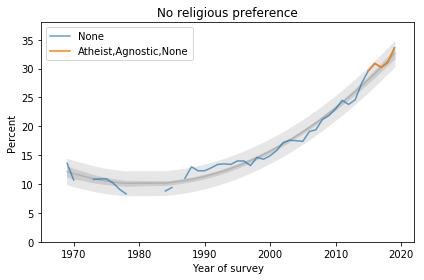

In [10]:
formula = 'y ~ time + time2'
plot_model(df, y, formula, color='C0', alpha=0.7, label='None')

y2.plot(color='C1', label='Atheist,Agnostic,None')
decorate(title='No religious preference',
         xlabel='Year of survey',
                 ylabel='Percent', 
                 xlim=xlim, 
                 ylim=[0, 38])
savefig('heri.1')

Fitting a quadratic model to percentages is a bit nonsensical, since percentages can't exceed 1.  It would probably be better to work in terms of log-odds, particularly if we are interested in forecasting what might happen after we cross the 50% line.  But for now the simple model is fine.

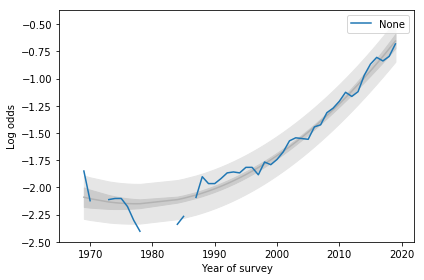

In [11]:
ps = df.noneall / 100
odds = ps / (1-ps)
log_odds = np.log(odds)
log_odds
plot_model(df, log_odds, formula, color='C0', label='None')
decorate(xlabel='Year of survey', xlim=xlim, ylabel='Log odds')

Plot the fraction of students reporting attendance at religious services, along with a quadratic model.

In [12]:
attend = df['attendedall'].copy()

# I'm discarding the data point from 1966, 
# which seems unreasonably low
attend[1966] = np.nan

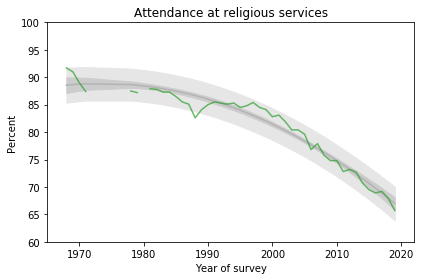

In [13]:
plot_model(df, attend, formula, 
           color='C2', alpha=0.7, 
           label='_nolegend')
decorate(title='Attendance at religious services', 
         xlabel='Year of survey',
                 ylabel='Percent',
                 xlim=xlim, 
                 ylim=[60, 100])
savefig('heri.3')

Plot the gender gap along with a quadratic model.

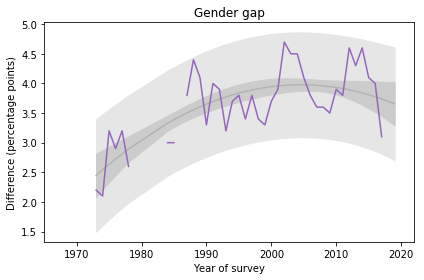

In [14]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1973:]
plot_model(df, diff, formula, 
           color='C4', alpha=1, label='_nolegend')
decorate(title='Gender gap', 
         xlabel='Year of survey',
         ylabel='Difference (percentage points)',
         xlim=xlim)
savefig('heri.2')

To see whether the gender gap is still increasing, we can fit a quadatic model to the most recent data.

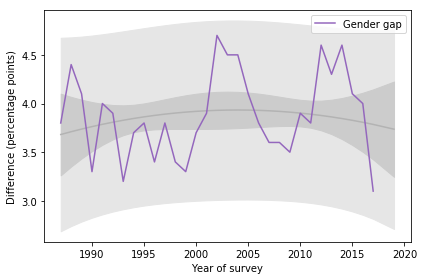

In [15]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1986:]
plot_model(df, diff, formula, color='C4', label='Gender gap')
decorate(xlabel='Year of survey',
         ylabel='Difference (percentage points)')

A linear model for the most recent data suggests that the gap might not be growing.

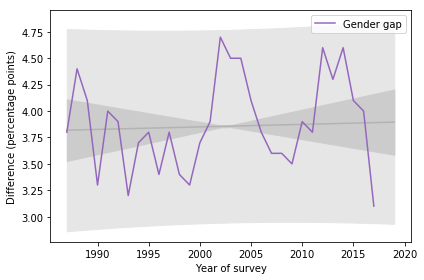

In [16]:
diff = df.nonemen - df.nonewomen
diff = diff.loc[1986:]
plot_model(df, diff, 'y ~ time', color='C4', label='Gender gap')
decorate(xlabel='Year of survey',
         ylabel='Difference (percentage points)')